In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

In [2]:
# 自定义数据集类
class FERPlusDataset(Dataset):
    def __init__(self, fer_df, ferplus_df, data_type='Training', transform=None):
        self.fer_df = fer_df
        self.ferplus_df = ferplus_df
        self.data_type = data_type
        self.transform = transform
        self.images, self.labels = self._load_and_preprocess_data()

    def _load_and_preprocess_data(self):
        images = []
        labels = []
        usage = self.ferplus_df['Usage']

        for i in range(len(self.fer_df)):
            if usage[i] == self.data_type:
                pixel_str = self.fer_df['pixels'][i]
                pixel_list = [int(pixel) for pixel in pixel_str.split()]
                image = np.array(pixel_list, dtype=np.uint8).reshape(48, 48)
                images.append(image)

                label = np.argmax([int(x) for x in self.ferplus_df.iloc[i, 2:10]])
                labels.append(label)

        images = np.array(images)
        labels = np.array(labels)
        images = images / 255.0

        return images, labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = Image.fromarray((image * 255).astype(np.uint8))
            image = self.transform(image)
        else:
            image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

In [6]:
# Create Residual Block
class ResBlock(nn.Module):
    def __init__(self, in_channel, out_channel, stride=1, size_change=None):
        super(ResBlock, self).__init__()

        # one convolution layer in each block
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride, padding=1, bias=False)

        # batch normalization for conv1
        self.bn = nn.BatchNorm2d(out_channel)

        # relu activation function
        self.relu = nn.ReLU(inplace=True)

        # match inter-block dimensions
        self.convert_size = size_change

        # dropout layer to prevent overfitting (random 50%)
        self.dropout = nn.Dropout2d(0.5)

    def forward(self, x):
        res = x

        out = self.conv1(x)
        out = self.bn(out)

        # adjust residual if dimensions do not match
        if self.convert_size is not None:
            res = self.convert_size(res)

        # add residual
        out += res

        out = self.relu(out)
        out = self.dropout(out)

        return out

# Create 6 layers Residual Network
class ResNet(nn.Module):
    def __init__(self, classes_num=10):
        super(ResNet, self).__init__()

        # preprocess layer
        self.preprocess = self._make_preprocess_layer()

        # 4 residual layers
        self.layer1 = self._make_layer(in_channel=64, out_channel=64, block_num=1, stride=1)
        self.layer2 = self._make_layer(in_channel=64, out_channel=128, block_num=1, stride=2, check_schange=True)
        self.layer3 = self._make_layer(in_channel=128, out_channel=256, block_num=1, stride=2, check_schange=True)
        self.layer4 = self._make_layer(in_channel=256, out_channel=512, block_num=1, stride=2, check_schange=True)

        # classification layer
        self.classifier = self._make_classifier(classes_num)

    def _make_preprocess_layer(self):
        return nn.Sequential(
            # convert input into residual processing format
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def _make_layer(self, in_channel, out_channel, block_num, stride, check_schange=False):
        size_change = None

        # adjust input size for inter-block value
        if check_schange:
            size_change = nn.Sequential(
                nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channel)
            )

        # add residual blocks to a list
        layers = []
        layers.append(ResBlock(in_channel, out_channel, stride, size_change))

        for _ in range(1, block_num):
            layers.append(ResBlock(out_channel, out_channel))

        return nn.Sequential(*layers)

    def _make_classifier(self, classes_num):
        return nn.Sequential(
            # global average pooling
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            # fully connected classifier layers (3)
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, classes_num)
        )

    def forward(self, x):
        x = self.preprocess(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.classifier(x)
        return x

In [4]:
# 评估模型
def evaluate_model(model, dataloader, criterion, device, is_final=False):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)

    if is_final:
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')
        conf_matrix = confusion_matrix(all_labels, all_preds)

        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 - score: {f1}")
        print("Confusion Matrix:")
        print(conf_matrix)

        return accuracy, precision, recall, f1, conf_matrix
    return avg_loss, accuracy

Epoch 1 Training Loss: 1.6160, Training Accuracy: 0.3624
Epoch 1 Validation Loss: 1.5934, Validation Accuracy: 0.3725
Epoch 2 Training Loss: 1.5748, Training Accuracy: 0.3736
Epoch 2 Validation Loss: 1.5631, Validation Accuracy: 0.4040
Epoch 3 Training Loss: 1.5178, Training Accuracy: 0.4319
Epoch 3 Validation Loss: 1.4506, Validation Accuracy: 0.4714
Epoch 4 Training Loss: 1.4523, Training Accuracy: 0.4706
Epoch 4 Validation Loss: 1.3696, Validation Accuracy: 0.5079
Epoch 5 Training Loss: 1.3853, Training Accuracy: 0.5036
Epoch 5 Validation Loss: 1.3026, Validation Accuracy: 0.5411
Epoch 6 Training Loss: 1.3344, Training Accuracy: 0.5240
Epoch 6 Validation Loss: 1.2462, Validation Accuracy: 0.5534
Epoch 7 Training Loss: 1.2956, Training Accuracy: 0.5421
Epoch 7 Validation Loss: 1.2132, Validation Accuracy: 0.5709
Epoch 8 Training Loss: 1.2680, Training Accuracy: 0.5487
Epoch 8 Validation Loss: 1.1710, Validation Accuracy: 0.5879
Epoch 9 Training Loss: 1.2465, Training Accuracy: 0.5594

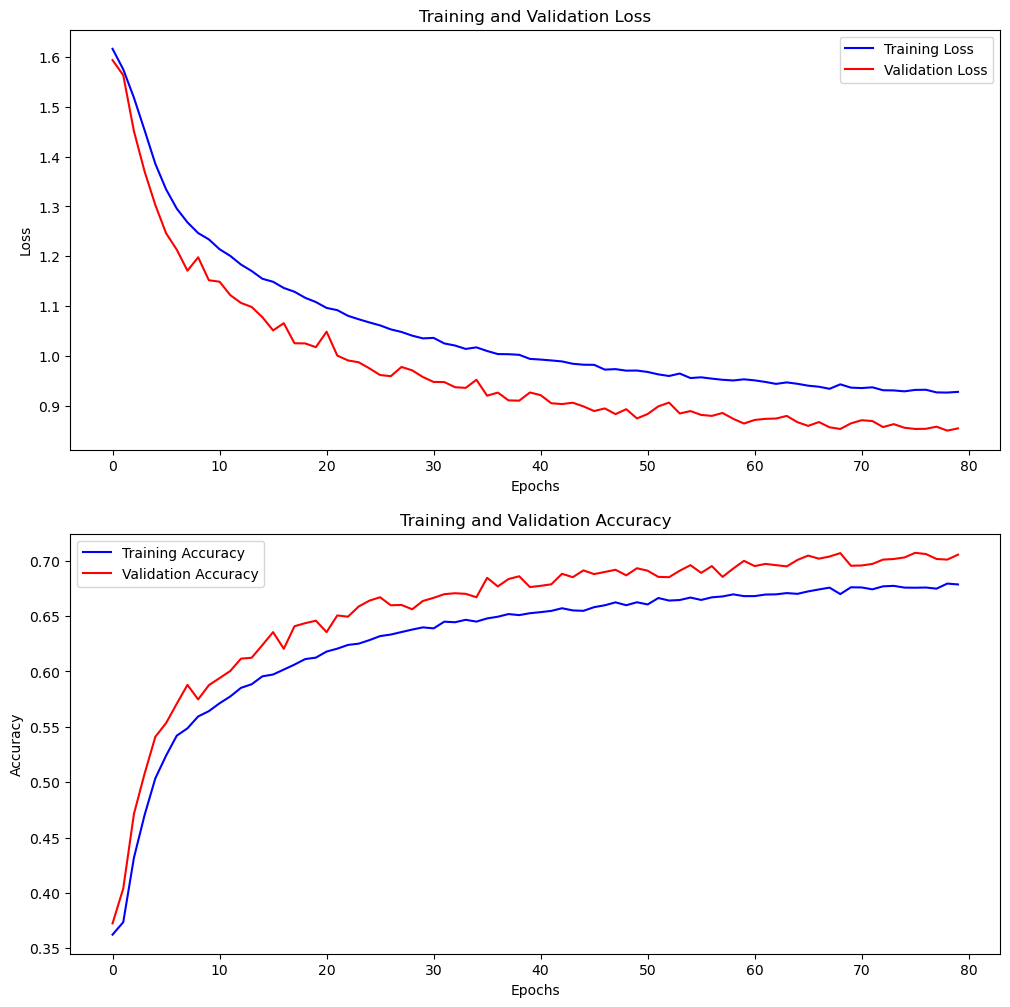

In [5]:
# 主函数
def main():
    fer_path = 'fer2013.csv'
    ferplus_path = 'fer2013new.csv'
    fer_df = pd.read_csv(fer_path)
    ferplus_df = pd.read_csv(ferplus_path)

    # 数据增强
    train_transform = transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])

    train_dataset = FERPlusDataset(fer_df, ferplus_df, data_type='Training', transform=train_transform)
    valid_dataset = FERPlusDataset(fer_df, ferplus_df, data_type='PrivateTest')
    test_dataset = FERPlusDataset(fer_df, ferplus_df, data_type='PublicTest')

    batch_size = 32
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ResNet().to(device)

    criterion = nn.CrossEntropyLoss()
    learning_rate = 0.0001
    # 正则化：添加 L2 正则化（权重衰减）
    weight_decay = 0.003
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    epochs = 80
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []

        for i, (images, labels) in enumerate(train_dataloader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().tolist())
            train_labels.extend(labels.cpu().tolist())

        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)
        train_accuracy = accuracy_score(train_labels, train_preds)
        train_accuracies.append(train_accuracy)
        print(f"Epoch {epoch + 1} Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

        valid_loss, valid_accuracy = evaluate_model(model, valid_dataloader, criterion, device, is_final=False)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)
        print(f"Epoch {epoch + 1} Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}")

    print("Training Finished. Training Set Evaluation:")
    evaluate_model(model, train_dataloader, criterion, device, is_final=True)

    print("Validation Set Final Evaluation:")
    evaluate_model(model, valid_dataloader, criterion, device, is_final=True)

    print("Test Set Evaluation:")
    evaluate_model(model, test_dataloader, criterion, device, is_final=True)

    # 训练过程可视化
    plt.figure(figsize=(12, 12))

    # 绘制损失曲线
    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(valid_losses, label='Validation Loss', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 绘制准确率曲线
    plt.subplot(2, 1, 2)
    plt.plot(train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(valid_accuracies, label='Validation Accuracy', color='red')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


if __name__ == "__main__":
    main()